In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
from cmcrameri import cm
import matplotlib.transforms as mtransforms
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    dnew = ds.copy(deep=True)
    oindex = dnew.time
    dnew = dnew.diff('time') / (dnew.time.diff('time').astype(float) / 1e9 )
    dnew = dnew.reindex(time=oindex)
    return dnew[1:]

In [4]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    """

    # accumulated variables & scaling factors
    accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                        'ttr': 1,
                        'tsr': 1,
                        'str': 1,
                        'ssr': 1,
                        'e': 1}
    accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                'ttr': 'W m$^{-2}$',
                                'tsr': 'W m$^{-2}$',
                                'str': 'W m$^{-2}$',
                                'ssr': 'W m$^{-2}$',
                                'e': 'm s$^{-1}$'}
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    ds2 = ds1.copy(deep=True)

    # # convert accumulated variables into instantaneous
    # for var, sf in accumulated_vars.items():
    #     if var in ds2.keys():
    #         var_name = var+"_rate" 
    #         ds2 = ds2.assign(new=lambda x: accum2rate(x[var]) * sf)
    #         ds2 = ds2.rename_vars({'new':str(var_name)})
    #         ds2[var_name].loc[dict(time=ds2.time[1:])] = accum2rate(ds2[var]) * sf
    #         # set first value to equal zero,
    #         # should be zero but isn't always
    #         ds2[var_name].loc[dict(time=ds2.time[0])] = 0
    #         ds2[var_name].attrs['units'] = accumulated_var_newunits[var]
    return ds2

In [5]:
def hourly2accum(ds, start_day='2023-10-18 09', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

# Import data

In [6]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
babet_exp = {}
for exp in file_dir.keys():
    babet_exp[exp] = xr.open_mfdataset(os.path.join(file_dir[exp], '*.nc'), preprocess=preproc_ds)

In [7]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Calculate cumulative total precipitation

ERA5: sum up 

IFS: Already cumulative from initialisation, just need to subtract precip at start of window

In [8]:
starttime = '2023-10-19 00' # used to be 18th # Same as Met Office, https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2023/2023_08_storm_babet.pdf
endtime = '2023-10-22 00' # Met Office uses 9 hours more

In [9]:
tp_era = hourly2accum(era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_babet_exp = {key:(value.tp.sel(time=endtime)-value.tp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}


In [10]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

tp_min = 0 # Precipitation in mm
tp_max = 200

p_min = 970 # Pressure in hPa
p_max= 1030

In [11]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

# CURR v ERA5

In [11]:
projection = ccrs.PlateCarree()

longitude =tp_era.longitude.values
latitude = tp_era.latitude.values
ini = '2023-10-17'

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# --- ERA5 UK ----------------------
# figure and map setup
fig = plt.figure(1, figsize=(10, 7))
ax = plt.subplot(2,2,1, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_era.values
p_vals = era5.msl.sel(time=endtime).values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')

plt.title('ERA5')

# --- CURR UK ----------------------
# figure and map setup
ax = plt.subplot(2,2,2, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_babet_exp['curr'].sel(inidate=ini).mean(dim='number').values
p_vals = babet_exp['curr'].sel(inidate=ini).msl.sel(time=endtime).mean(dim='number').values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')

plt.title(f'CURR, inidate {ini}')

# -------------- all of Europe --------------
lat_max = 70
lat_min = 33
lon_min = -27
lon_max = 25

# --- ERA5 EU ----------------------
# figure and map setup
ax = plt.subplot(2,2,3, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_era.values
p_vals = era5.msl.sel(time=endtime).values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')
plt.title('ERA5')

# --- CURR EU ----------------------
# figure and map setup
ax = plt.subplot(2,2,4, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_babet_exp['curr'].sel(inidate=ini).mean(dim='number').values
p_vals = babet_exp['curr'].sel(inidate=ini).msl.sel(time=endtime).mean(dim='number').values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')
plt.title(f'CURR, inidate {ini}')

# colourbar, title etc
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Total precipitation (mm)')
plt.suptitle('Cumulative precip for 18th to 22nd Oct 2023')

Text(0.5, 0.98, 'Cumulative precip for 18th to 22nd Oct 2023')

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


# Comparison of precip in all simulations

In [27]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

tp_min = 0 # Precipitation in mm
tp_max = 200

p_min = 970 # Pressure in hPa
p_max= 1030

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


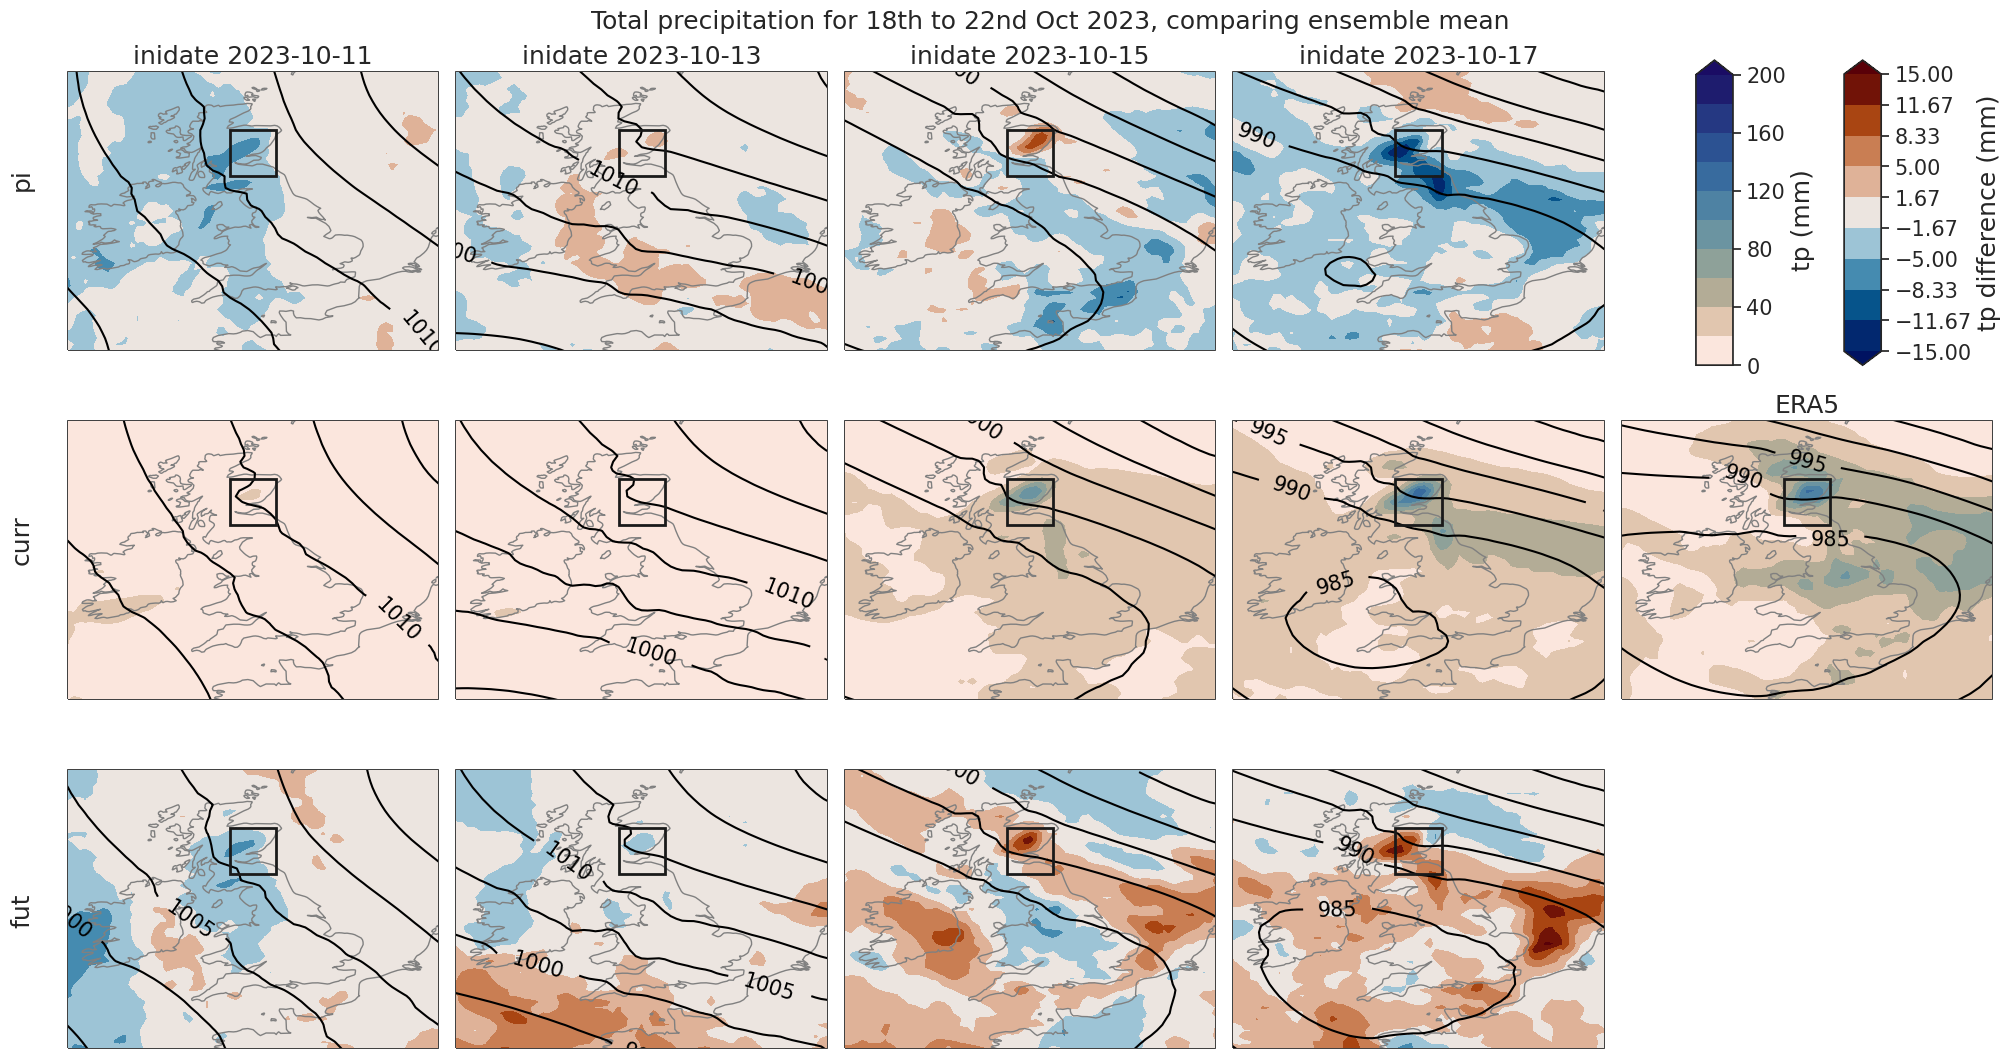

In [29]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 200

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=slice(starttime, endtime))/100).mean(dim=['number', 'time']).msl.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            tp_vals = (tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number') - tp_babet_exp['curr'].sel(inidate=inidate).mean(dim='number')).values
        else: 
            tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        # ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_tp = np.linspace(-15, 15, 10)
            cf_diff = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.msl.sel( time=slice(starttime, endtime)).mean('time').values/100
tp_vals = tp_era.values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
# ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp (mm)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='tp difference (mm)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='tp difference (mm)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Total precipitation for 18th to 22nd Oct 2023, comparing ensemble mean', size = fs)
plt.tight_layout()

plt.savefig('figures/03_tp_all-inidates_all-experiments.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/03_tp_all-inidates_all-experiments.pdf')

In [43]:
# figure and map setup
from tkinter import font


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 200

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=slice(starttime, endtime))/100).mean(dim=['number', 'time']).msl.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            tp_vals = (tp_babet_exp[experiment].sel(inidate=inidate).quantile(0.9,dim='number') - tp_babet_exp['curr'].sel(inidate=inidate).quantile(0.9,dim='number')).values
        else: 
            tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).quantile(0.9,dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_tp = np.linspace(-15, 15, 11)
            cf_diff = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.msl.sel(time=endtime).values/100
tp_vals = tp_era.values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp (mm)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='tp difference (mm)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='tp difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Comparing precip (19th-21st) with 90th perc. of ensemble', fontsize = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


# Change in precip compared to CC

In [13]:
# comparing the 90th percentile of ensemble as in plot
# dt2m = {}
# dtp = {}
# inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
# for inidate in inidates:
#     dt2m[inidate] = {}
#     dtp[inidate] = {}

#     t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').quantile(0.9, dim='number').mean(dim=['latitude', 'longitude'])
#     tp_curr = tp_babet_exp['curr'].sel(inidate=inidate).quantile(0.9, dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])
#     for exp in ['pi', 'incr']:
#         dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').quantile(0.9, dim='number').sum(dim=['latitude', 'longitude']) - t2m_curr)
#         dtp[inidate][exp] = (tp_babet_exp[exp].sel(inidate=inidate).quantile(0.9, dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - tp_curr)/tp_curr

#         # calculate change per kelvin of temperature change
#         dtpdt = dtp[inidate][exp]/dt2m[inidate][exp]
#         print(f'{exp} {inidate}: {dtpdt.values}')

In [ ]:
# comparing the mean
dt2m = {}
dtp = {}
for inidate in inidates:
    dt2m[inidate] = {}
    dtp[inidate] = {}

    t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude'])
    tp_curr = tp_babet_exp['curr'].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude']) - t2m_curr)
        dtp[inidate][exp] = (tp_babet_exp[exp].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - tp_curr)/tp_curr

        # calculate change per kelvin of temperature change
        dtpdt = dtp[inidate][exp]/dt2m[inidate][exp]
        print(f'{exp} {inidate}: {dtpdt.values}')

pi 2023-10-11: 0.32882463932037354
incr 2023-10-11: -0.29243168234825134
pi 2023-10-13: -0.10057850182056427
incr 2023-10-13: -0.21483176946640015
pi 2023-10-15: -0.031605977565050125
incr 2023-10-15: 0.13778109848499298
pi 2023-10-17: 0.1859041303396225
incr 2023-10-17: 0.12191622704267502


In [11]:
# load global temperature data
glob_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/GLO100/sfc/pf'
glob_file_dir = {'curr': glob_dir.format('curr'),
            'pi': glob_dir.format('pi'),
            'incr': glob_dir.format('incr')}
babet_exp_glob = {}
for exp in file_dir.keys():
    babet_exp_glob[exp] = xr.open_mfdataset(os.path.join(glob_file_dir[exp], '*.nc'), preprocess=preproc_ds, engine='netcdf4')

In [13]:
# comparing the mean to global temperature
dt2m = {}
dtp = {}
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
for inidate in inidates:
    dt2m[inidate] = {}
    dtp[inidate] = {}

    t2m_curr = babet_exp_glob['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude'])
    tp_curr = tp_babet_exp['curr'].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp_glob[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude']) - t2m_curr)
        dtp[inidate][exp] = (tp_babet_exp[exp].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - tp_curr)/tp_curr

        # calculate change per kelvin of temperature change
        dtpdt = dtp[inidate][exp]/dt2m[inidate][exp]
        print(f'{exp} {inidate}: {dtpdt.values}')

pi 2023-10-11: 0.3700254261493683
incr 2023-10-11: -0.16151311993598938
pi 2023-10-13: -0.09510285407304764
incr 2023-10-13: -0.11248283833265305
pi 2023-10-15: -0.029649700969457626
incr 2023-10-15: 0.0640006810426712
pi 2023-10-17: 0.1860736757516861
incr 2023-10-17: 0.05064413696527481


In [14]:
# local temperature change over Scotland
dt2m = {}
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

for inidate in inidates:
    dt2m[inidate] = {}

    t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']) - t2m_curr)

        print(f'{exp} {inidate}: {dt2m[inidate][exp].values}')

pi 2023-10-11: -1.148681640625
incr 2023-10-11: 0.675750732421875
pi 2023-10-13: -0.756622314453125
incr 2023-10-13: 0.371612548828125
pi 2023-10-15: -1.072723388671875
incr 2023-10-15: 0.82562255859375
pi 2023-10-17: -0.90625
incr 2023-10-17: 0.85235595703125


In [15]:
# local temperature change over Scotland over full time period
dt2m = {}
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

for inidate in inidates:
    dt2m[inidate] = {}

    t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time=slice(starttime, endtime)).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude', 'time'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time=slice(starttime, endtime)).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude', 'time']) - t2m_curr)

        print(f'{exp} {inidate}: {dt2m[inidate][exp].values}')

pi 2023-10-11: -1.59161376953125
incr 2023-10-11: 0.954803466796875
pi 2023-10-13: -0.840972900390625
incr 2023-10-13: 0.4334716796875
pi 2023-10-15: -0.661865234375
incr 2023-10-15: 0.379608154296875
pi 2023-10-17: -0.78240966796875
incr 2023-10-17: 0.74468994140625


# Cumulative distribtions and statistical significance

In [14]:
tp_babet_exp_aberdeen = {key: tp_babet_exp[key].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']) for key in tp_babet_exp.keys()} 
tp_era_aberdeen = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

pi 2023-10-15


curr 2023-10-15
incr 2023-10-15
pi 2023-10-17
curr 2023-10-17
incr 2023-10-17


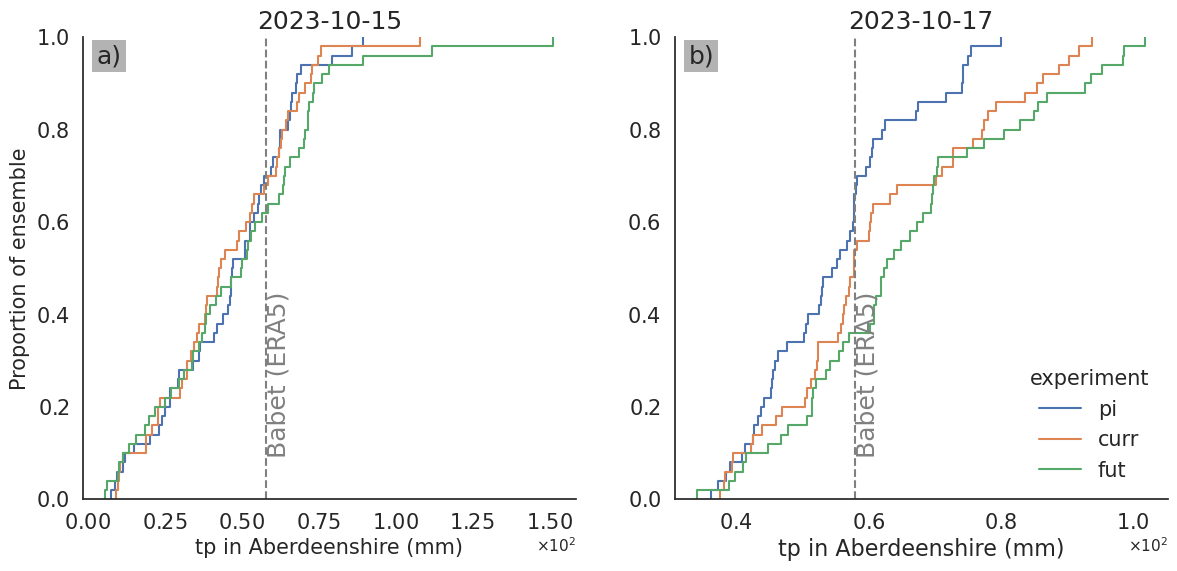

<Figure size 640x480 with 0 Axes>

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (14,6))
lead_times = ['4 days lead', '2 days lead']
labels = ['a)', 'b)']
fs = 18

inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']
for i, inidate in enumerate(inidates): 
    for e, experiment in enumerate(experiments): 
        print(experiment, inidate)
        sns.ecdfplot(tp_babet_exp_aberdeen[experiment].sel(inidate=inidate), label = experiment, ax = (ax1, ax2)[i]) #, color = get_palette.Petroff6().to_sn_palette()[e])

# -------------------------------------------------------

ax1.set_xlabel('tp in Aberdeenshire (mm)', fontsize=fs-3)
ax1.set_ylabel('Proportion of ensemble', fontsize=fs-3)
ax1.set_title(inidates[0], fontsize=fs)
ax1.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
ax1.tick_params(axis='both', which='major', labelsize=fs-3)
ax1.axvline(tp_era_aberdeen, linestyle='dashed', color='grey')
ax1.text(tp_era_aberdeen+0.08, 0.1, 'Babet (ERA5)', color='grey', rotation='vertical', fontsize=fs)

# subplot label
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, labels[0], transform=ax1.transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# -------------------------------------------------------

ax2.set_xlabel('tp in Aberdeenshire (mm)', fontsize=fs-2)
ax2.set_ylabel('', fontsize=fs-3)
ax2.set_title(inidates[1], fontsize=fs)
ax2.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
ax2.tick_params(axis='both', which='major', labelsize=fs-3)
ax2.axvline(tp_era_aberdeen, linestyle='dashed', color='grey')
ax2.text(tp_era_aberdeen+0.08, 0.1, 'Babet (ERA5)', color='grey', rotation='vertical', fontsize=fs)

ax2.text(0.0, 1.0, labels[1], transform=ax2.transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# -------------------------------------------------------

sns.despine()
plt.legend(['pi', 'curr', 'fut'], title = "experiment", fontsize=fs-3, frameon=False, title_fontsize=fs-3, loc='lower right')

plt.show()
plt.savefig('03_tp_cumulative_distribution_aberdeen.png', dpi=600, bbox_inches='tight')
plt.savefig('03_tp_cumulative_distribution_aberdeen.pdf')

In [17]:
# KS test for statistical significance
print('15th October')
ini = '2023-10-15'
print('PI cs CURR: ', sc.stats.kstest(tp_babet_exp_aberdeen['pi'].sel(inidate=inidate), tp_babet_exp_aberdeen['curr'].sel(inidate=inidate)).pvalue)
print('PI cs INCR: ', sc.stats.kstest(tp_babet_exp_aberdeen['pi'].sel(inidate=inidate), tp_babet_exp_aberdeen['incr'].sel(inidate=inidate)).pvalue)
print('CURR cs INCR ', sc.stats.kstest(tp_babet_exp_aberdeen['curr'].sel(inidate=inidate), tp_babet_exp_aberdeen['incr'].sel(inidate=inidate)).pvalue)

15th October
PI cs CURR:  0.17858668181221732
PI cs INCR:  0.0005822568814776493
CURR cs INCR  0.06779471096995852


In [18]:
print('17th October')
ini = '2023-10-17'
print('PI cs CURR: ', sc.stats.kstest(tp_babet_exp_aberdeen['pi'].sel(inidate=inidate), tp_babet_exp_aberdeen['curr'].sel(inidate=inidate)).pvalue)
print('PI cs INCR: ', sc.stats.kstest(tp_babet_exp_aberdeen['pi'].sel(inidate=inidate), tp_babet_exp_aberdeen['incr'].sel(inidate=inidate)).pvalue)
print('CURR cs INCR ', sc.stats.kstest(tp_babet_exp_aberdeen['curr'].sel(inidate=inidate), tp_babet_exp_aberdeen['incr'].sel(inidate=inidate)).pvalue)

17th October
PI cs CURR:  0.17858668181221732
PI cs INCR:  0.0005822568814776493
CURR cs INCR  0.06779471096995852


# Members in pi, ini 15th

In [16]:
# Calculate unit vector of wind
level = 1000
experiments = ['pi', 'curr', 'incr']
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (babet_exp[experiment].u10 / np.sqrt(babet_exp[experiment].u10**2 + babet_exp[experiment].v10**2))
    v[experiment] = (babet_exp[experiment].v10 / np.sqrt(babet_exp[experiment].u10**2 + babet_exp[experiment].v10**2))

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


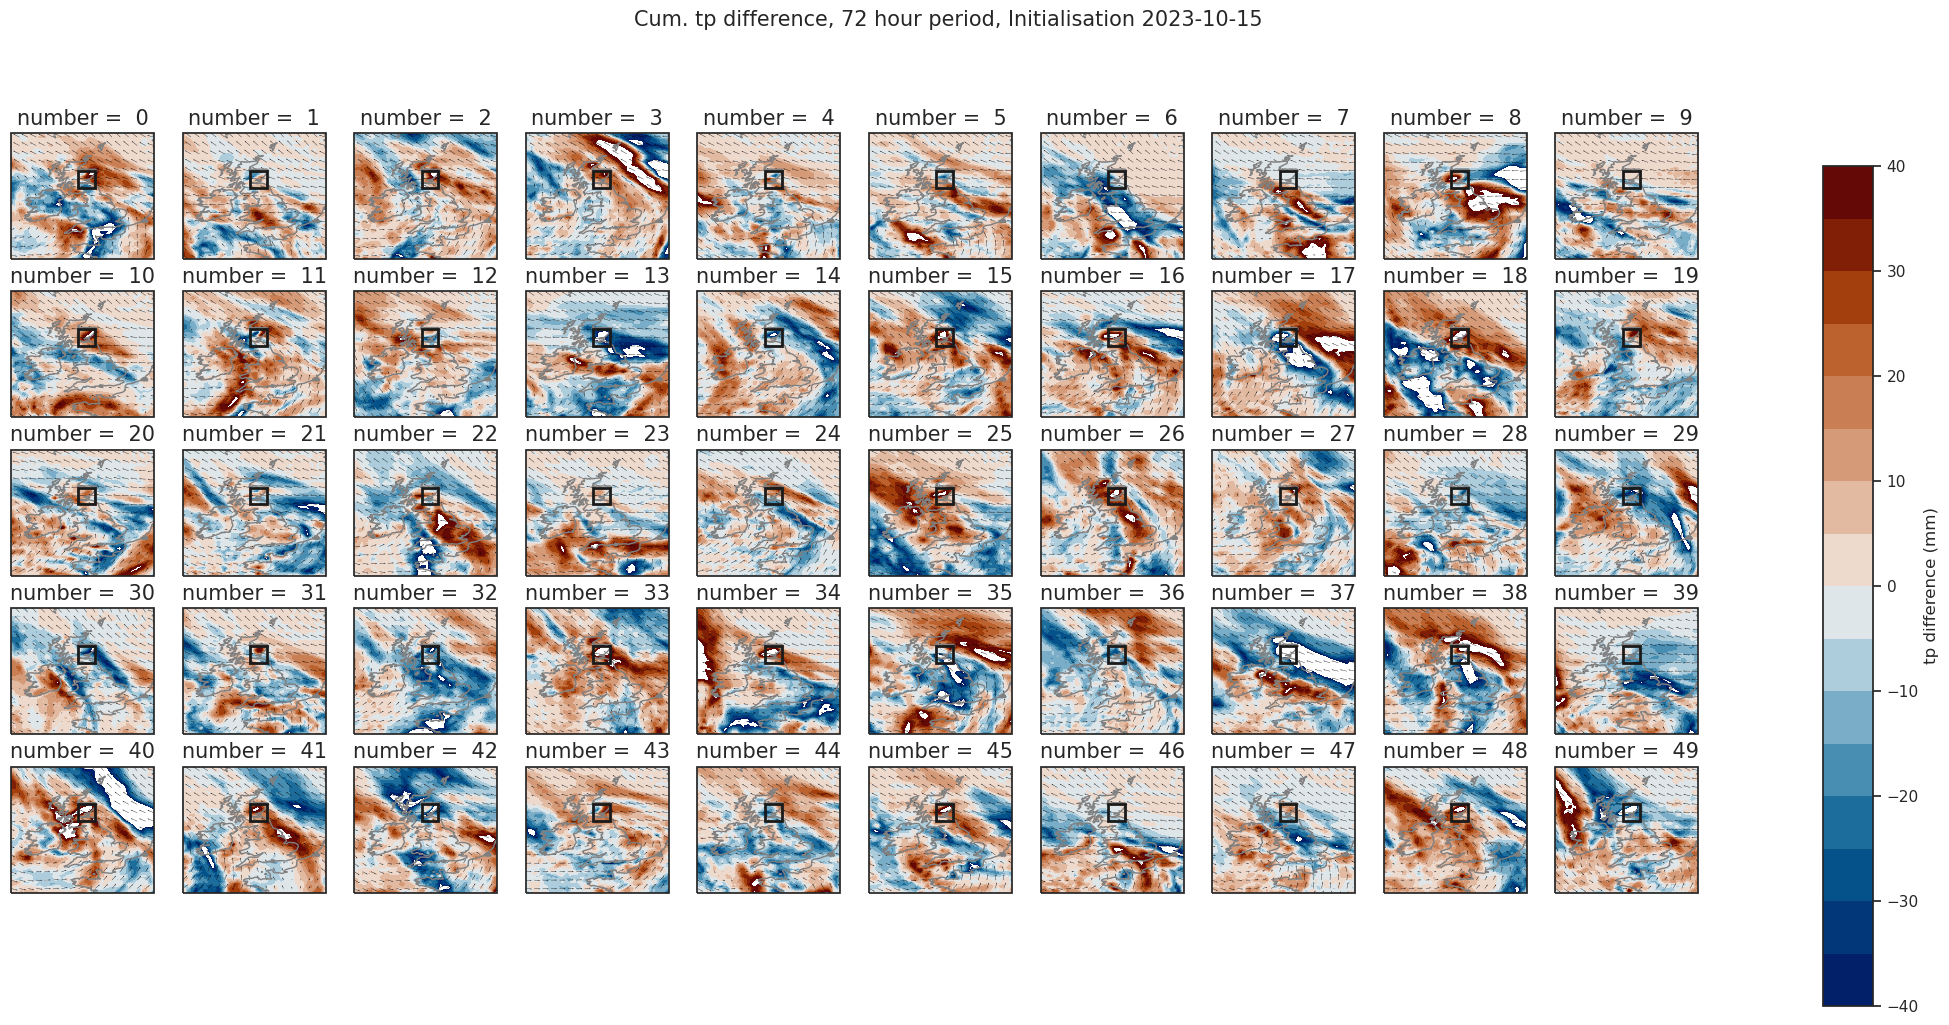

In [13]:
projection = ccrs.PlateCarree()
inidate = '2023-10-15'
fig = plt.figure(1, figsize=(25, 12))
tp_diff = tp_babet_exp['pi'].sel(inidate=inidate) - tp_babet_exp['curr'].sel(inidate=inidate)
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

for m in range(50):
    fg10_vals = tp_diff.values[m,:,:]
    p_vals = babet_exp['pi'].sel(inidate=inidate, time=slice(starttime, endtime)).mean('time').msl.values[m,:,:]/100
    longitude = tp_diff.longitude.values
    latitude = tp_diff.latitude.values

    # figure and map setup
    ax = plt.subplot(6,10,m+1, projection = projection)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # fg10 as shading
    clevs_fg10 = np.linspace(-40, 40, 17)
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=cm.vik,
                    transform=projection)

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax.quiver(llon, llat, 
        u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=m+1).mean('time')[::stride, ::stride], 
        v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=m+1).mean('time')[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=20, color='black')
    # # isobars as contours
    # clevs_p = np.linspace(960, 1050, 17)
    # cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
    #                 transform=projection)
    # plt.clabel(cs, fmt='%d')

    # rectangle for Aberdeenshire box
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                    edgecolor='k', 
                                    facecolor='none',
                                    transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

    ax.set_title("number =  "+ str(m), size=15)

plt.suptitle('Cum. tp difference, 72 hour period, Initialisation '+inidate, size=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='tp difference (mm)')
plt.savefig(f'figures/03_tp_diff_pi-curr_{inidate}.png', dpi=300, bbox_inches='tight')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


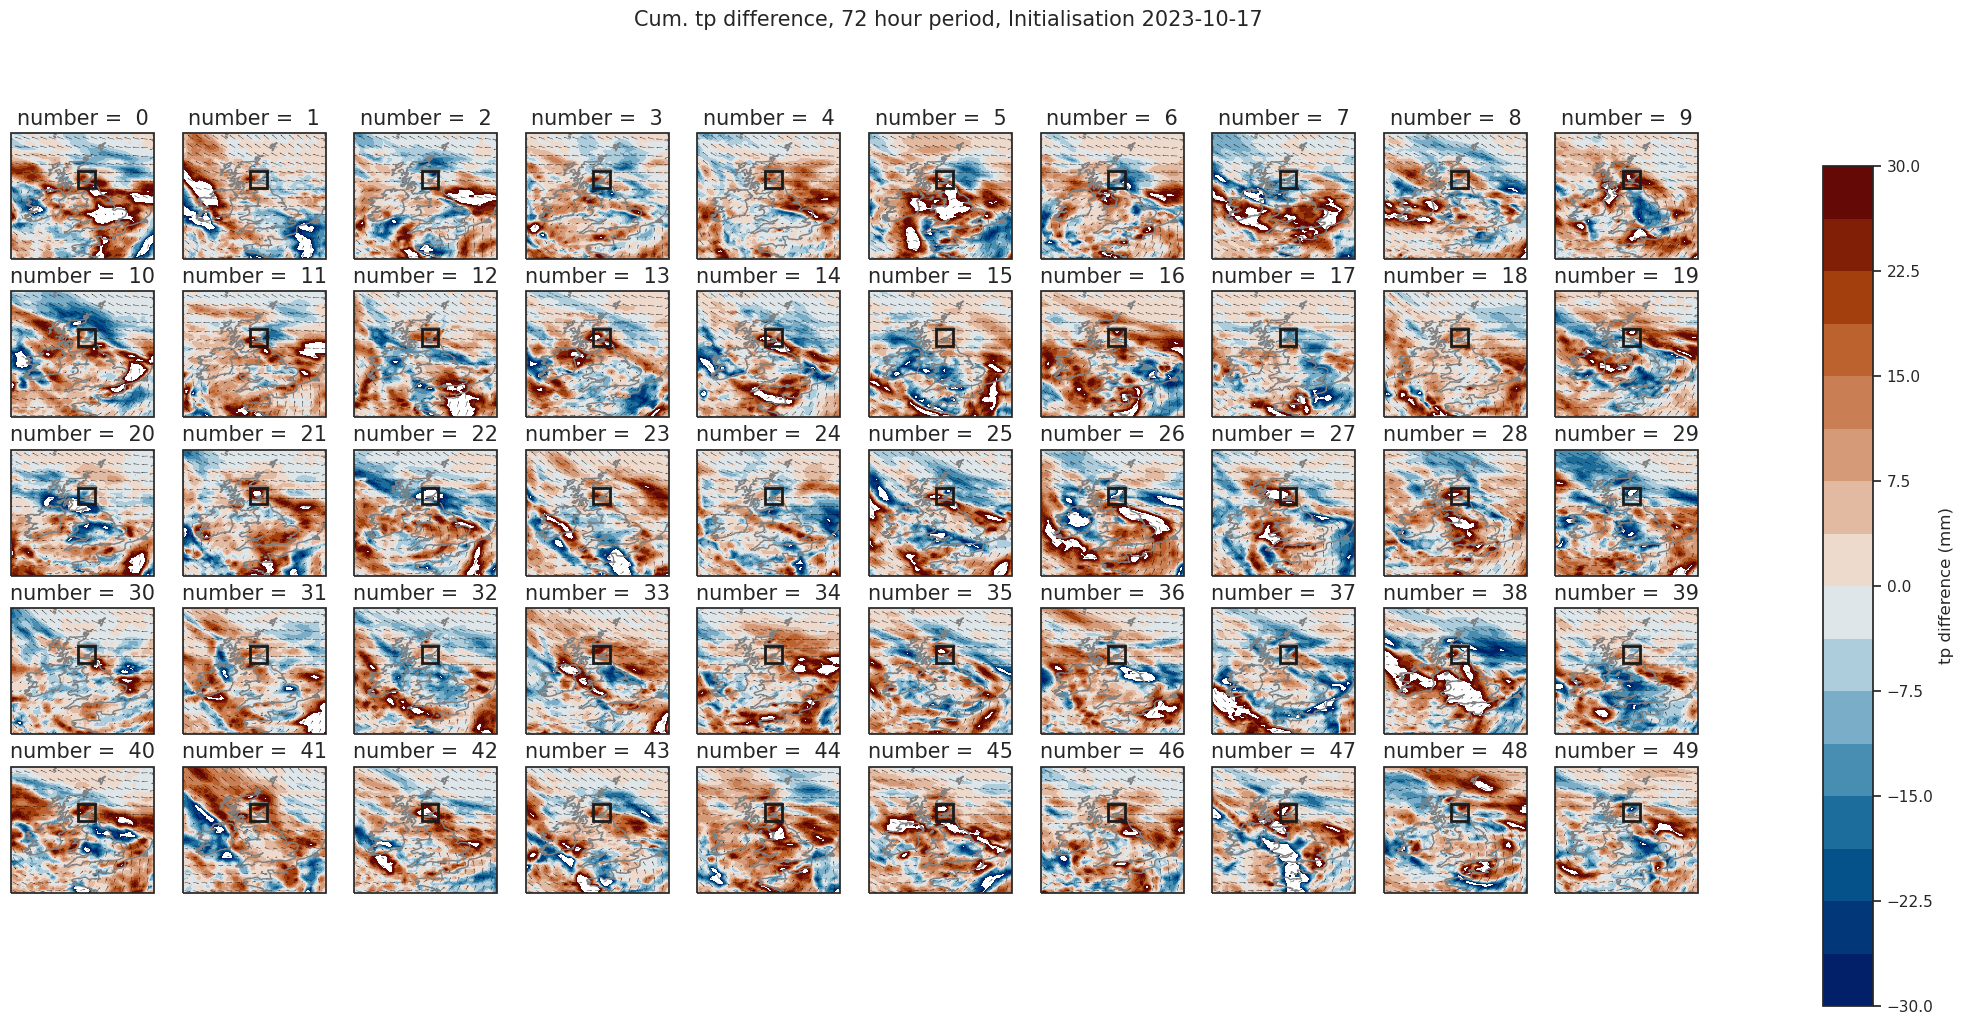

In [31]:
projection = ccrs.PlateCarree()
inidate = '2023-10-17'
fig = plt.figure(1, figsize=(25, 12))
tp_diff = tp_babet_exp['incr'].sel(inidate=inidate) - tp_babet_exp['curr'].sel(inidate=inidate)
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

for m in range(50):
    fg10_vals = tp_diff.values[m,:,:]
    p_vals = babet_exp['pi'].sel(inidate=inidate, time=slice(starttime, endtime)).mean('time').msl.values[m,:,:]/100
    longitude = tp_diff.longitude.values
    latitude = tp_diff.latitude.values

    # figure and map setup
    ax = plt.subplot(6,10,m+1, projection = projection)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # fg10 as shading
    clevs_fg10 = np.linspace(-30, 30, 17)
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=cm.vik,
                    transform=projection)
    
    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax.quiver(llon, llat, 
        u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=m+1).mean('time')[::stride, ::stride], 
        v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=m+1).mean('time')[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=20, color='black')

    # # isobars as contours
    # clevs_p = np.linspace(960, 1050, 17)
    # cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
    #                 transform=projection)
    # plt.clabel(cs, fmt='%d')

    # rectangle for Aberdeenshire box
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                    edgecolor='k', 
                                    facecolor='none',
                                    transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

    ax.set_title("number =  "+ str(m), size=15)

plt.suptitle('Cum. tp difference, 72 hour period, Initialisation '+inidate, size=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='tp difference (mm)')
plt.savefig(f'figures/03_tp_diff_pi-curr_{inidate}.png', dpi=300, bbox_inches='tight')

Median 15th: 0.42310846
Median 17th: -6.8814354
Mean 15th: 0.9758303
Mean 17th: -6.489801


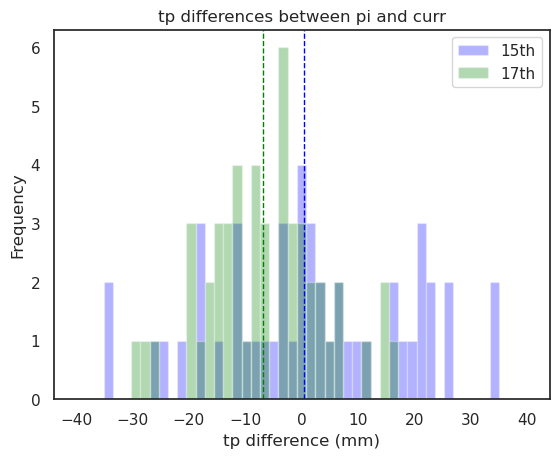

In [14]:
inidate = '2023-10-15'
tp_diff = tp_babet_exp['pi'].sel(inidate=inidate) - tp_babet_exp['curr'].sel(inidate=inidate)
tp_diff_aberdeen_15 = tp_diff.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

inidate = '2023-10-17'
tp_diff = tp_babet_exp['pi'].sel(inidate=inidate) - tp_babet_exp['curr'].sel(inidate=inidate)
tp_diff_aberdeen_17 = tp_diff.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

plt.figure()
bins = np.linspace(-40, 40, 50)
plt.hist(tp_diff_aberdeen_15.values, bins=bins, label='15th', alpha=0.3, color='blue')
plt.hist(tp_diff_aberdeen_17.values, bins=bins, label='17th', alpha=0.3, color='green')
plt.xlabel('tp difference (mm)')
plt.ylabel('Frequency')
plt.title(f'tp differences between pi and curr')

# vertical lines for median
plt.axvline(np.median(tp_diff_aberdeen_15.values), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.median(tp_diff_aberdeen_17.values), color='green', linestyle='dashed', linewidth=1)
print('Median 15th:', np.median(tp_diff_aberdeen_15.values))
print('Median 17th:', np.median(tp_diff_aberdeen_17.values))

print('Mean 15th:', np.mean(tp_diff_aberdeen_15.values))
print('Mean 17th:', np.mean(tp_diff_aberdeen_17.values))

plt.legend()

plt.savefig('figures/03_tp_diff_hist.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/03_tp_diff_hist.pdf')

# Composites for pi ini 15

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


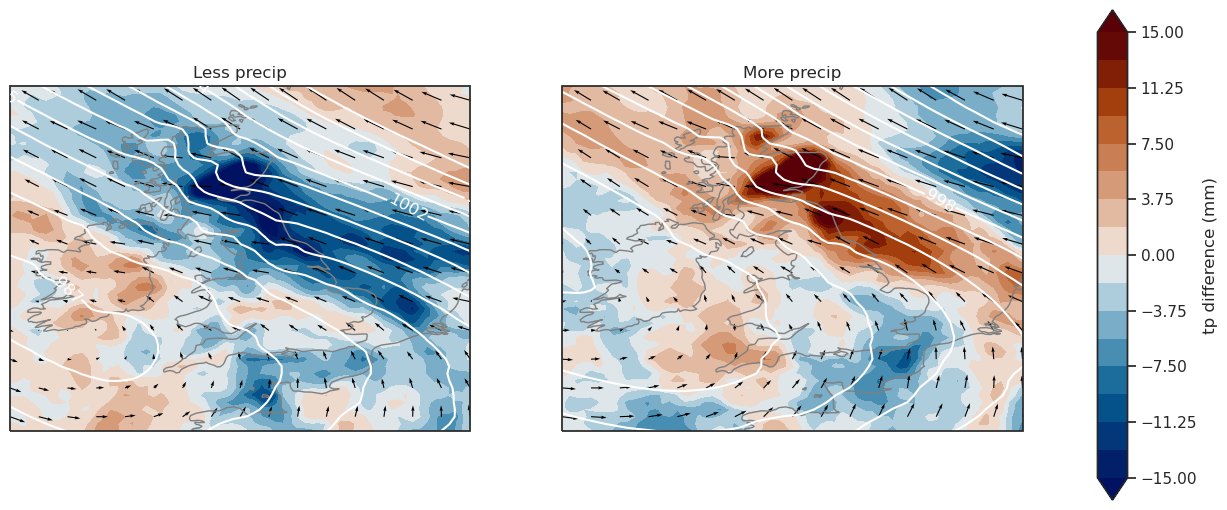

In [17]:
# Select pi ensemble members with less cumulative precip than curr
inidate = '2023-10-15'
tp_diff = tp_babet_exp['pi'].sel(inidate='2023-10-15') - tp_babet_exp['curr'].sel(inidate='2023-10-15')
tp_diff_aberdeen_15 = tp_diff.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])
less_precip = tp_diff_aberdeen_15.where(tp_diff_aberdeen_15 < 0, drop=True)

# Select pi ensemble members with more cumulative precip than curr
more_precip = tp_diff_aberdeen_15.where(tp_diff_aberdeen_15 > 0, drop=True)

# Plot precip and msl for less and more precip ensemble members

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

tp_min = -15
tp_max = 15
clevs_tp = np.linspace(tp_min, tp_max, 17)

p_min = 980
p_max = 1010
clevs_p = np.linspace(p_min, p_max, 17)
fig = plt.figure(1, figsize=(15, 7))

latitude = tp_babet_exp['pi'].latitude.values
longitude = tp_babet_exp['pi'].longitude.values
 
projection = ccrs.PlateCarree()
ax = plt.subplot(1,2,1, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# ----- Less precip ------
# data for plotting
tp_vals = (tp_babet_exp['pi'].sel(number=less_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=less_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['pi'].sel(number=less_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=20, color='black')

plt.title('Less precip')

# ----- More precip ------
ax = plt.subplot(1,2,2, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = (tp_babet_exp['pi'].sel(number=more_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=more_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['pi'].sel(number=more_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=20, color='black')

plt.title('More precip')

# colourbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='tp difference (mm)')
plt.savefig(f'figures/03_tp_diff_pi-curr_{inidate}_less-more_10m_winds.png', dpi=300, bbox_inches='tight')

In [18]:
less_precip.number.count().values, more_precip.number.count().values

(array(24), array(26))

The same plot but with 925hPa winds

In [19]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
babet_exp_pl = {}
for exp in file_dir.keys():
    babet_exp_pl[exp] = xr.open_mfdataset(os.path.join(file_dir[exp], '*.nc'), preprocess=preproc_ds)

In [20]:
# Calculate vector of wind
level = 925
experiments = ['pi', 'curr', 'incr']
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (babet_exp_pl[experiment].sel(level=level).u) #/ np.sqrt(babet_exp_pl[experiment].sel(level=level).u**2 + babet_exp_pl[experiment].sel(level=level).v**2))
    v[experiment] = (babet_exp_pl[experiment].sel(level=level).v) #/ np.sqrt(babet_exp_pl[experiment].sel(level=level).u**2 + babet_exp_pl[experiment].sel(level=level).v**2))

In [23]:
# Select pi ensemble members with less cumulative precip than curr
inidate = '2023-10-15'
tp_diff = tp_babet_exp['pi'].sel(inidate='2023-10-15') - tp_babet_exp['curr'].sel(inidate='2023-10-15')
tp_diff_aberdeen_15 = tp_diff.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])
less_precip = tp_diff_aberdeen_15.where(tp_diff_aberdeen_15 < 0, drop=True)

# Select pi ensemble members with more cumulative precip than curr
more_precip = tp_diff_aberdeen_15.where(tp_diff_aberdeen_15 > 0, drop=True)

# Plot precip and msl for less and more precip ensemble members

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

tp_min = -15
tp_max = 15
clevs_tp = np.linspace(tp_min, tp_max, 17)

pmin = 980
pmax = 1010
clevs_p = np.linspace(p_min, p_max, 17)
fig = plt.figure(1, figsize=(15, 7))

latitude = tp_babet_exp['pi'].latitude.values
longitude = tp_babet_exp['pi'].longitude.values
 
projection = ccrs.PlateCarree()
ax = plt.subplot(1,2,1, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# ----- Less precip ------
# data for plotting
tp_vals = (tp_babet_exp['pi'].sel(number=less_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=less_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['pi'].sel(number=less_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=200, color='black')

plt.title('Less precip')

# ----- More precip ------
ax = plt.subplot(1,2,2, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
latitude = tp_babet_exp['pi'].latitude.values
longitude = tp_babet_exp['pi'].longitude.values
tp_vals = (tp_babet_exp['pi'].sel(number=more_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=more_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['pi'].sel(number=more_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['pi'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=200, color='black')

plt.title('More precip')

# colourbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='tp difference (mm)')
plt.savefig(f'figures/03_tp_diff_pi-curr_{inidate}_less-more_925_winds.png', dpi=300, bbox_inches='tight')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


In [25]:
# Plot wind vectors of composites in one plot
from numpy import less


inidate = '2023-10-15'
experiments = ['pi', 'curr', 'incr']
fig = plt.figure(1, figsize=(18, 8))

latitude = tp_babet_exp['pi'].latitude.values
longitude = tp_babet_exp['pi'].longitude.values
 
projection = ccrs.PlateCarree()

for e, experiment in enumerate(experiments):
    ax = plt.subplot(1,3,e+1, projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # less precip
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax.quiver(llon, llat, 
        u[experiment].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
        v[experiment].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=200, color='blue')

    # more precip
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax.quiver(llon, llat, 
        u[experiment].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
        v[experiment].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=200, color='red')

    plt.title(f'Winds at 925 hPa, {experiment}, {inidate}')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


In [23]:
# Plot precip and msl for less and more precip ensemble members

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

tp_min = -15
tp_max = 15
clevs_tp = np.linspace(tp_min, tp_max, 17)

pmin = 970
pmax = 1000
clevs_p = np.linspace(p_min, p_max, 17)
fig = plt.figure(1, figsize=(15, 7))

latitude = tp_babet_exp['pi'].latitude.values
longitude = tp_babet_exp['pi'].longitude.values
 
projection = ccrs.PlateCarree()
ax = plt.subplot(1,2,1, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# ----- Less precip ------
# data for plotting
tp_vals = (tp_babet_exp['incr'].sel(number=less_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=less_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['incr'].sel(number=less_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['incr'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['incr'].sel(time=slice(starttime, endtime), inidate=inidate, number=less_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=200, color='black')

plt.title('Less precip')

# ----- More precip ------
ax = plt.subplot(1,2,2, projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
latitude = tp_babet_exp['incr'].latitude.values
longitude = tp_babet_exp['incr'].longitude.values
tp_vals = (tp_babet_exp['incr'].sel(number=more_precip.number.values, inidate='2023-10-15') - tp_babet_exp['curr'].sel(number=more_precip.number.values, inidate='2023-10-15')).mean(dim='number').values
p_vals = babet_exp['incr'].sel(number=more_precip.number.values, inidate='2023-10-15').msl.sel(time=slice(starttime, endtime)).mean(dim=['number', 'time']).values/100

# tp as shading
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                transform=projection, 
                extend='both')

# isobars as contours
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='white',
                transform=projection)
plt.clabel(cs, fmt='%d')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
    u['incr'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    v['incr'].sel(time=slice(starttime, endtime), inidate=inidate, number=more_precip.number.values).mean(['time', 'number'])[::stride, ::stride], 
    transform=ccrs.PlateCarree(), scale=200, color='black')

plt.title('More precip')

# colourbar 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='tp difference (mm)')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


# Time series of precipitation

In [17]:
tp_babet_exp = {key:(value.tp-value.tp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}

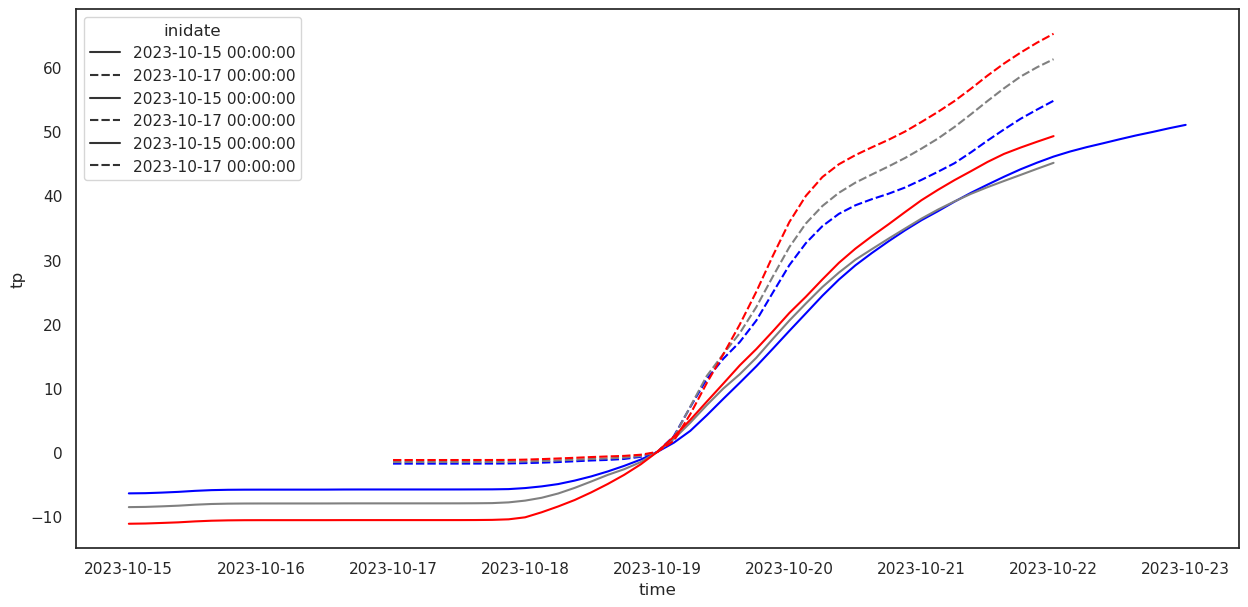

In [18]:
# Plot precip in time for all experiments
fig = plt.figure(1, figsize=(15, 7))
tp_vals = {}
colors = ['blue', 'gray', 'red']
for e, experiment in enumerate(experiments):
    tp_vals[experiment] = tp_babet_exp[experiment].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2), inidate=['2023-10-15', '2023-10-17']).mean(dim=['latitude', 'longitude', 'number']).to_dataframe().reset_index()
    g = sns.lineplot(data=tp_vals[experiment], x="time", y="tp", style="inidate", color=colors[e])

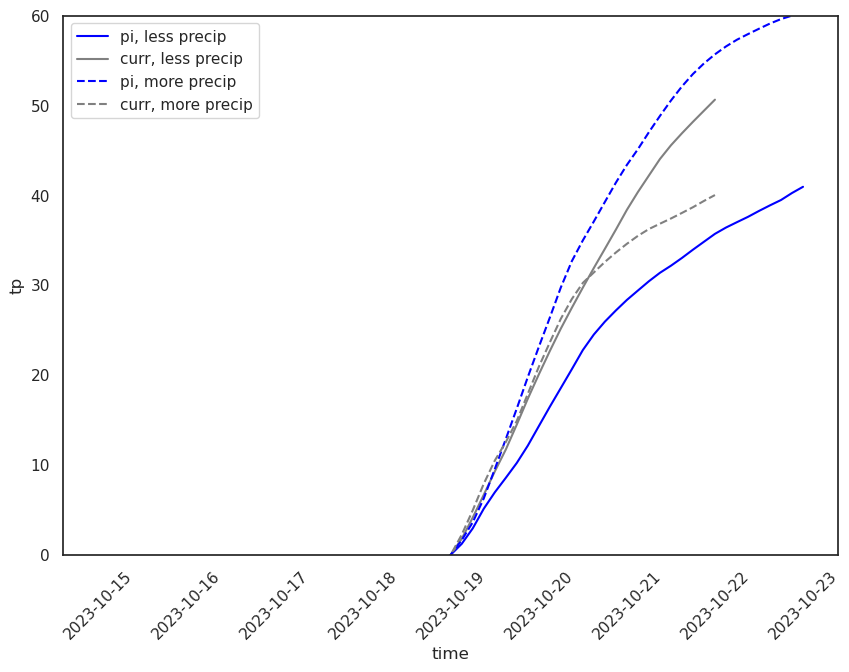

In [20]:
# Time line for pi, 15 composites
inidate = '2023-10-15'
fig = plt.figure(1, figsize=(10, 7))

# Less precip
ax = plt.subplot(1,1,1)
tp_vals_pi = tp_babet_exp['pi'].sel(inidate=inidate).sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2), number=less_precip.number.values).mean(dim=['latitude', 'longitude', 'number'])
tp_vals_curr = tp_babet_exp['curr'].sel(inidate=inidate).sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2), number=less_precip.number.values).mean(dim=['latitude', 'longitude', 'number'])

sns.lineplot(data=tp_vals_pi.to_dataframe().reset_index(), x="time", y="tp", color='blue', label='pi, less precip')
sns.lineplot(data=tp_vals_curr.to_dataframe().reset_index(), x="time", y="tp", color='gray', label='curr, less precip')
plt.ylim(-3, 60)
plt.xticks(rotation=45)

# More precip
# ax = plt.subplot(1,2,2)
tp_vals_pi = tp_babet_exp['pi'].sel(inidate=inidate).sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2), number=more_precip.number.values).mean(dim=['latitude', 'longitude', 'number'])
tp_vals_curr = tp_babet_exp['curr'].sel(inidate=inidate).sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2), number=more_precip.number.values).mean(dim=['latitude', 'longitude', 'number'])

sns.lineplot(data=tp_vals_pi.to_dataframe().reset_index(), x="time", y="tp", color='blue', linestyle='--', label='pi, more precip')
sns.lineplot(data=tp_vals_curr.to_dataframe().reset_index(), x="time", y="tp", color='gray', linestyle='--', label='curr, more precip')
plt.ylim(0, 60)
plt.xticks(rotation=45)

plt.savefig('figures/03_tp_time_series_composites_pi_and_curr.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/03_tp_time_series_composites_pi_and_curr.pdf')


# Member to member comparison

In [13]:
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
for inidate in inidates:

    for exp in ['pi', 'incr']:
        for number in range(1, 50):
            temp_cc = []
            # CURR values
            temp_curr_t2m = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00', number=number).mean(dim=['latitude', 'longitude'])
            temp_curr_tp = tp_babet_exp['curr'].sel(inidate=inidate, number=number, latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude'])
            
            # difference between corresponding ensemble members
            temp_dt2m = (babet_exp[exp].t2m.sel(inidate=inidate, 
            time='2023-10-19 00', number=number).mean(dim=['latitude', 'longitude']) - temp_curr_t2m)
            temp_tp = (tp_babet_exp[exp].sel(inidate=inidate, number=number, latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - temp_curr_tp)/temp_curr_tp
            temp_cc.append((temp_tp/temp_dt2m).values)

        # calculate change per kelvin of temperature change
        dtpdt = np.mean(temp_cc)
        print(f'{exp} {inidate}: {dtpdt}')

pi 2023-10-11: 1.2308589220046997
incr 2023-10-11: -1.810776948928833
pi 2023-10-13: 0.1808878481388092
incr 2023-10-13: -0.8993769884109497
pi 2023-10-15: -0.8272947072982788
incr 2023-10-15: 0.2660737931728363
pi 2023-10-17: 0.3730998933315277
incr 2023-10-17: -0.06364905834197998


# Ensemble spread

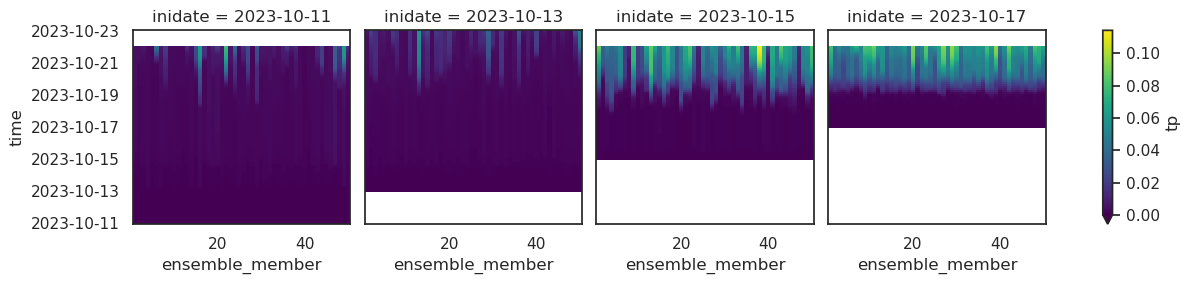

In [35]:
babet_exp['curr'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

In [36]:
babet_exp['pi'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

In [37]:
babet_exp['incr'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

In [38]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

In [39]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 1.4

fig = plt.figure(1, figsize=(18, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=endtime)/100).mean(dim='number').msl.values
        tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).std(dim='number').values/tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp std as shading
        clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.bilbao,
                        transform=projection, zorder = 10, extend = 'max')
        
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))


# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp std/mean', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

plt.figtext(0.0, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(0.0, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(0.0, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Ensemble std in tp')
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in t

# Type of precipitation

In [25]:
tp_era = hourly2accum(era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_babet_exp = {key:(value.tp.sel(time=endtime)-value.tp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}

In [26]:
# Calculate cumulative precipitation for cp and lsp
cp_cum_ecp = {key:(value.cp.sel(time=endtime)-value.cp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}
lsp_cum_ecp = {key:(value.lsp.sel(time=endtime)-value.lsp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}

In [27]:
# Calculate fraction of convective and large-scale precipitation
cp_frac = {key: (cp_cum_ecp[key]/tp_babet_exp[key]).mean(dim='number') for key in babet_exp.keys()}
lsp_frac = {key: (lsp_cum_ecp[key]/tp_babet_exp[key]).mean(dim='number') for key in babet_exp.keys()}

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


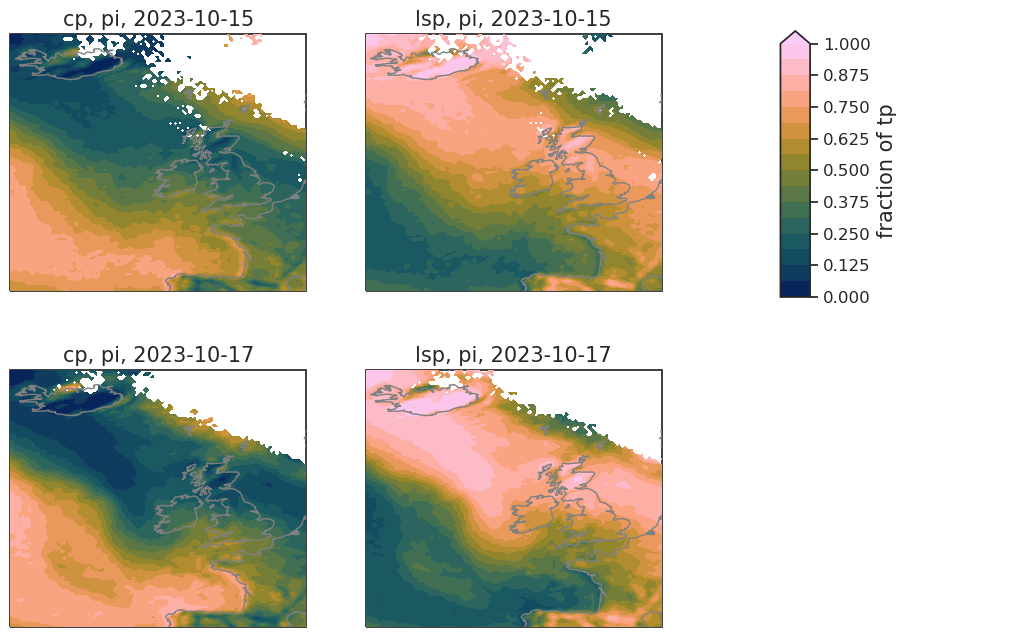

In [45]:
# Plot fraction of convective and large-scale precipitation for all experiments
projection = ccrs.PlateCarree()
fs = 15
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values
experiments = ['pi', 'curr', 'incr']

for experiment in experiments:
    fig = plt.figure(1, figsize=(13, 8))
    m=1
    for i, inidate in enumerate(['2023-10-15', '2023-10-17']):

        # convective precipitation
        ax = plt.subplot(2,3,m, projection = projection)
        ax.set_extent(euroatlantic, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

        cf = ax.contourf(longitude, latitude, cp_frac[experiment].sel(inidate=inidate), np.linspace(0,1, 17), cmap=cm.batlow,
                        transform=projection, zorder = 10, extend = 'max')
        ax.set_title(f'cp, {experiment}, {inidate}', size = fs)
        
        m+=1
        # large-scale precipitation
        ax = plt.subplot(2,3,m, projection = projection)
        ax.set_extent(euroatlantic, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

        cf = ax.contourf(longitude, latitude, lsp_frac[experiment].sel(inidate=inidate), np.linspace(0,1, 17), cmap=cm.batlow,
                        transform=projection, zorder = 10, extend = 'max')
        ax.set_title(f'lsp, {experiment}, {inidate}', size = fs)
        m+=2

    # Other figure settings -----------------
    ax = plt.subplot(2,3,3)
    ax.axis('off')  # removes subplot frame
    cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
    cbar = fig.colorbar(cf, cax=cax, label='fraction', extend = 'max', shrink=0.8)
    cbar.set_label(label='fraction of tp', size=fs)
    cbar.ax.tick_params(labelsize=fs-3)
    plt.show()


/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by

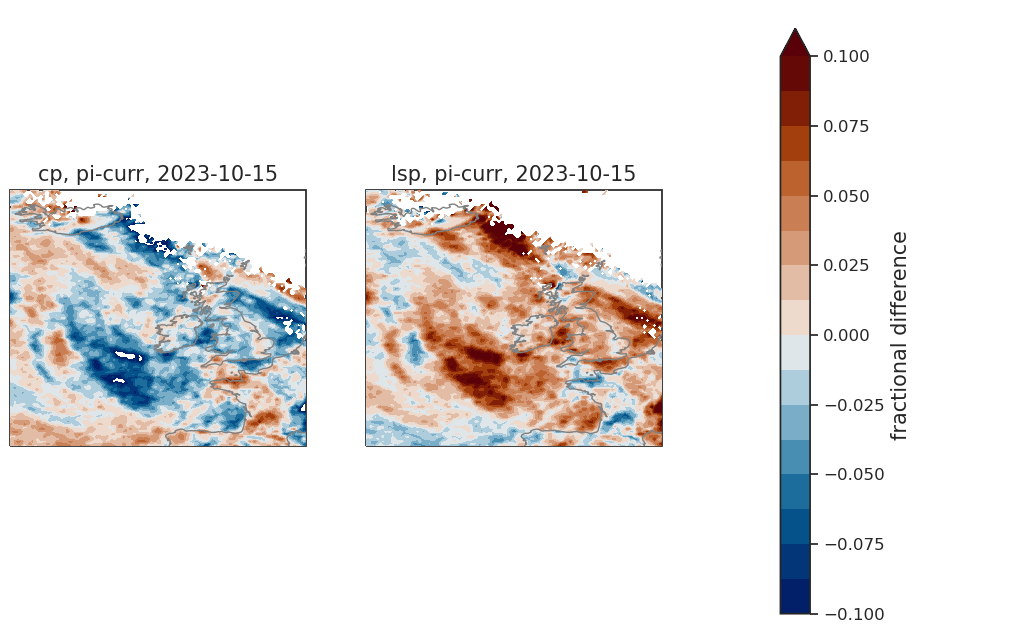

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by

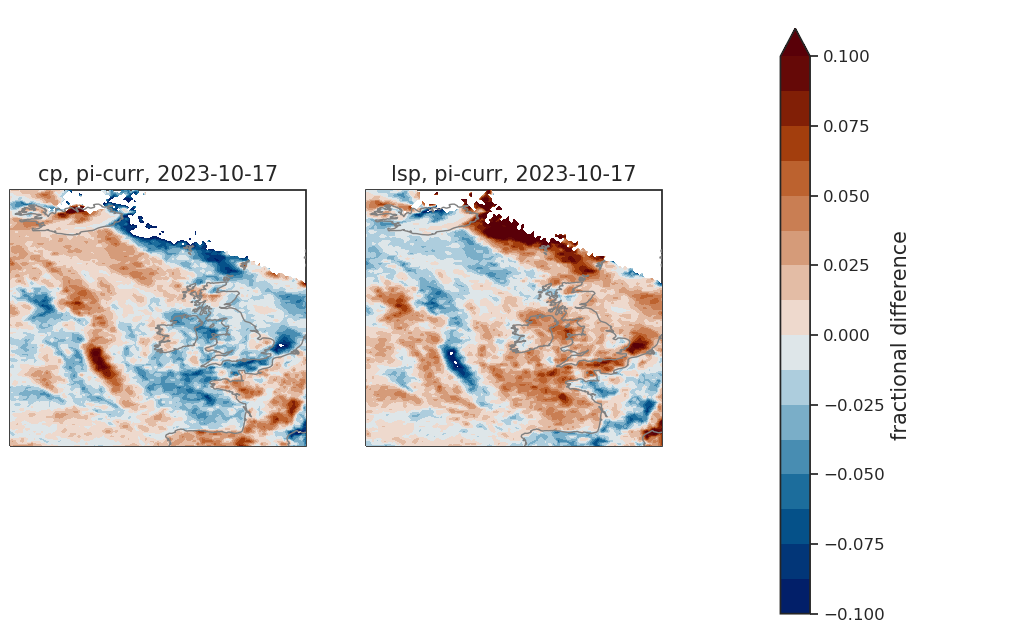

In [37]:
# plot difference betwee pi and curr
projection = ccrs.PlateCarree()
fs = 15
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values
experiments = ['pi', 'curr', 'incr']

for i, inidate in enumerate(['2023-10-15', '2023-10-17']):

    fig = plt.figure(1, figsize=(13, 8))

    # convective precipitation
    ax = plt.subplot(1,3,1, projection = projection)
    ax.set_extent(euroatlantic, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

    cf = ax.contourf(longitude, latitude, (cp_frac['pi']-cp_frac['curr']).sel(inidate=inidate), np.linspace(-0.1,0.1, 17), cmap=cm.vik,
                    transform=projection, zorder = 10, extend = 'max')
    ax.set_title(f'cp, pi-curr, {inidate}', size = fs)
    
    # large-scale precipitation
    ax = plt.subplot(1,3,2, projection = projection)
    ax.set_extent(euroatlantic, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

    cf = ax.contourf(longitude, latitude, (lsp_frac['pi']-lsp_frac['curr']).sel(inidate=inidate), np.linspace(-0.1,0.1, 17), cmap=cm.vik,
                    transform=projection, zorder = 10, extend = 'max')
    ax.set_title(f'lsp, pi-curr, {inidate}', size = fs)

    # Other figure settings -----------------
    ax = plt.subplot(1,3,3)
    ax.axis('off')  # removes subplot frame
    cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
    cbar = fig.colorbar(cf, cax=cax, label='fractional difference', extend = 'max', shrink=0.8)
    cbar.set_label(label='fractional difference', size=fs)
    cbar.ax.tick_params(labelsize=fs-3)
    plt.show()

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by

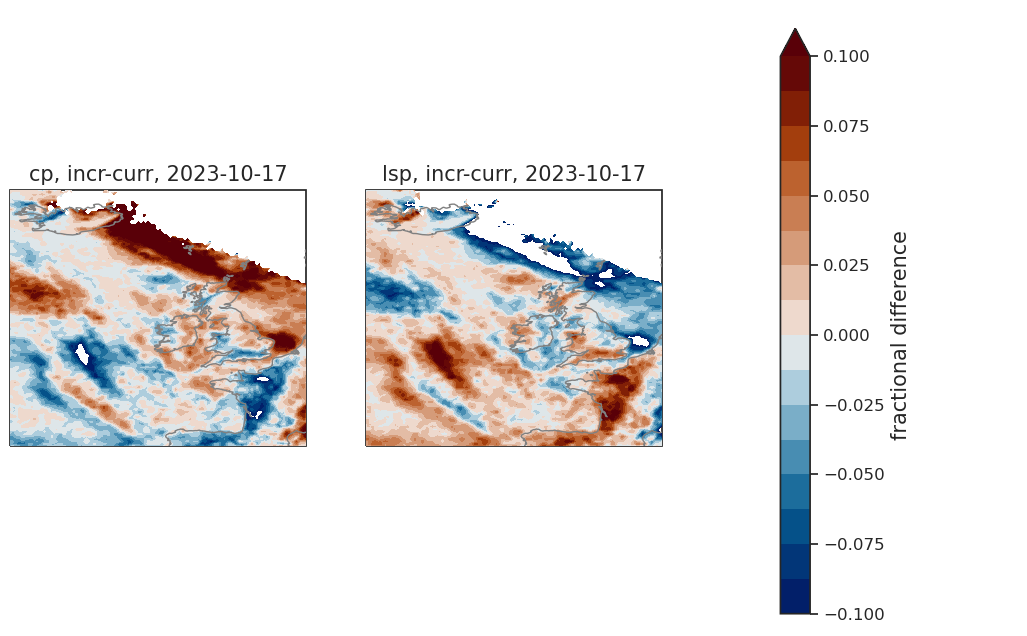

In [28]:
# plot difference betwee incr and curr
projection = ccrs.PlateCarree()
fs = 15
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values
experiments = ['pi', 'curr', 'incr']

for i, inidate in enumerate(['2023-10-15', '2023-10-17']):

    fig = plt.figure(1, figsize=(13, 8))

    # convective precipitation
    ax = plt.subplot(1,3,1, projection = projection)
    ax.set_extent(euroatlantic, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

    cf = ax.contourf(longitude, latitude, (cp_frac['incr']-cp_frac['curr']).sel(inidate=inidate), np.linspace(-0.1,0.1, 17), cmap=cm.vik,
                    transform=projection, zorder = 10, extend = 'max')
    ax.set_title(f'cp, incr-curr, {inidate}', size = fs)
    
    # large-scale precipitation
    ax = plt.subplot(1,3,2, projection = projection)
    ax.set_extent(euroatlantic, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)

    cf = ax.contourf(longitude, latitude, (lsp_frac['incr']-lsp_frac['curr']).sel(inidate=inidate), np.linspace(-0.1,0.1, 17), cmap=cm.vik,
                    transform=projection, zorder = 10, extend = 'max')
    ax.set_title(f'lsp, incr-curr, {inidate}', size = fs)

    # Other figure settings -----------------
    ax = plt.subplot(1,3,3)
    ax.axis('off')  # removes subplot frame
    cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
    cbar = fig.colorbar(cf, cax=cax, label='fractional difference', extend = 'max', shrink=0.8)
    cbar.set_label(label='fractional difference', size=fs)
    cbar.ax.tick_params(labelsize=fs-3)
    plt.show()